# Adaptive PDE discretizations on cartesian grids 
## Volume : GPU accelerated methods
## Part : Reproducibility
## Chapter : Curvature penalized models

In this notebook, we run some TTI models (Tilted Transversely Anisotropic), a kind of Finslerian manifold appearing in seismology, on the CPU and GPU, and check that they produce consistent results.

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"../..")
#from Miscellaneous import TocTools; print(TocTools.displayTOC('Rander_Repro','GPU'))

In [2]:
import cupy as cp
import numpy as np
import itertools
from matplotlib import pyplot as plt
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%5.3g" % x))

In [8]:
from agd import HFMUtils
from agd import AutomaticDifferentiation as ad
from agd import Metrics
from agd import FiniteDifferences as fd
from agd import LinearParallel as lp
from agd.Metrics.Seismic import Reduced
import agd.AutomaticDifferentiation.cupy_generic as cugen

norm_infinity = ad.Optimization.norm_infinity
from Notebooks_GPU.ExportedCode.Isotropic_Repro import RunCompare

In [15]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global HFMUtils,ad,cugen,Metrics,Reduced
    HFMUtils,ad,cugen,Metrics,Reduced = rreload([HFMUtils,ad,cugen,Metrics,Reduced],"../..")    
    HFMUtils.dictIn.RunSmart = cugen.cupy_get_args(HFMUtils.RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

In [16]:
cp = ad.functional.decorate_module_functions(cp,cugen.set_output_dtype32) # Use float32 and int32 types in place of float64 and int64
plt = ad.functional.decorate_module_functions(plt,cugen.cupy_get_args)
HFMUtils.dictIn.RunSmart = cugen.cupy_get_args(HFMUtils.RunSmart,dtype64=True,iterables=(dict,Metrics.Base))

# 1. Defining a seismic norm

In [80]:
ReloadPackages()

In [68]:
xp=cp
n=4
hfmIn_Constant = HFMUtils.dictIn({
    'model':'TTI2',
    'arrayOrdering':'RowMajor',
    'exportValues':1,
    'seeds':xp.array([[0.,0.]]),
    'factoringMethod':'Static',
    'factoringRadius':20,
    'seedRadius':0,
    'order':2
#    'tips':[[x,y] for y in HFMUtils.CenteredLinspace(-1,1,6) 
#                    for x in HFMUtils.CenteredLinspace(-1,1,6)],
#    'exportGeodesicFlow':1,
})

hfmIn_Constant.SetRect(sides=[[-1,1],[-1,1]],dimx=n+1,sampleBoundary=True) # Define the domain
X = hfmIn_Constant.Grid() # Horizontal and vertical axis

metric = Reduced(xp.array([1.,1]),xp.array([[0.5,0.1],[0.1,-0.2]])) #Linear and quadratic part
metric.rotate_by(xp.array(0.5))
hfmIn_Constant['metric'] = metric

Casting output of function array from float64 to float32
Casting output of function array from float64 to float32
Casting output of function array from float64 to float32
Casting output of function array from float64 to float32


In [84]:
x=ad.Dense2.identity(constant=cp.ones(2))
x+=2
x

Casting output of function ones from float64 to float32
in add


denseAD2(array([    3,     3], dtype=float32),
array([[    1,     0],
       [    0,     1]], dtype=float32),
array([[[    0,     0],
        [    0,     0]],

       [[    0,     0],
        [    0,     0]]], dtype=float32))

In [70]:
X_ad = ad.Dense2.identity(constant=X,shape_free=(2,))
metric._dual_level(X_ad)

<class 'agd.AutomaticDifferentiation.Dense2.denseAD2_cupy'>
in add
<class 'cupy.core.core.ndarray'> <class 'agd.AutomaticDifferentiation.Dense2.denseAD2_cupy'> <class 'agd.AutomaticDifferentiation.Dense2.denseAD2_cupy'>


denseAD2(array([[  1.5, 0.787,   0.5, 0.787,   1.5],
       [0.131, -0.469, -0.719, -0.469, 0.131],
       [ -0.2, -0.762,    -1, -0.762,  -0.2],
       [0.131, -0.469, -0.719, -0.469, 0.131],
       [  1.5, 0.787,   0.5, 0.787,   1.5]], dtype=float32),
array([[[ -4.4,  -1.6],
        [ -4.1,  -1.1],
        [   -4,     0],
        [ -4.1,   1.1],
        [ -4.4,   1.6]],

       [[-1.45,  -1.3],
        [ -1.3, -0.95],
        [-1.25,     0],
        [ -1.3,  0.95],
        [-1.45,   1.3]],

       [[    0,  -1.2],
        [    0,  -0.9],
        [    0,     0],
        [    0,   0.9],
        [    0,   1.2]],

       [[ 1.45,  -1.3],
        [  1.3, -0.95],
        [ 1.25,     0],
        [  1.3,  0.95],
        [ 1.45,   1.3]],

       [[  4.4,  -1.6],
        [  4.1,  -1.1],
        [    4,     0],
        [  4.1,   1.1],
        [  4.4,   1.6]]], dtype=float32),
array([[[[  8.4,   0.8],
         [  0.8,     0]],

        [[  8.1,   0.4],
         [  0.4,   1.8]],

        [[    8,

In [23]:
metric._gradient(X)

TypeError: Unsupported type <class 'agd.AutomaticDifferentiation.Dense2.denseAD2'>

TypeError: Unsupported type <class 'agd.AutomaticDifferentiation.Dense2.denseAD2'>

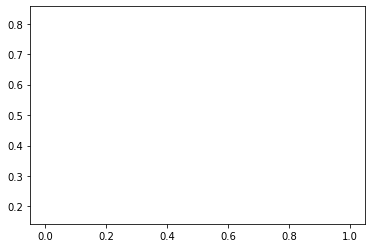

In [18]:
plt.axis('equal')
plt.contour(*X,metric.norm(X))